# Parte 1

In [1]:
import scapy.all as scapy
import pandas as pd
import matplotlib.pyplot as plt
import socket

# Cargar archivo pcap
pcap_file = "analisis_paquetes.pcap"
packets = scapy.rdpcap(pcap_file)

# Convertir paquetes a DataFrame
def extract_packet_info(packet):
    return {
        "src": packet[scapy.IP].src if packet.haslayer(scapy.IP) else None,
        "dst": packet[scapy.IP].dst if packet.haslayer(scapy.IP) else None,
        "sport": (packet[scapy.TCP].sport if packet.haslayer(scapy.TCP) 
                  else packet[scapy.UDP].sport if packet.haslayer(scapy.UDP) else "Desconocido"),
        "dport": (packet[scapy.TCP].dport if packet.haslayer(scapy.TCP) 
                  else packet[scapy.UDP].dport if packet.haslayer(scapy.UDP) else "Desconocido"),
        "payload": len(packet.payload),
        "time": packet.time
    }

data = [extract_packet_info(pkt) for pkt in packets if pkt.haslayer(scapy.IP)]
df = pd.DataFrame(data)

# Verificar si el DataFrame tiene datos
if df.empty:
    print("No se encontraron paquetes con capa IP en el archivo PCAP.")
else:
    # Rellenar valores NaN
    df["sport"] = df["sport"].fillna("Desconocido")
    df["dport"] = df["dport"].fillna("Desconocido")

    # Mostrar las primeras 5 filas
    print(df.head())

    # Estadísticas
    ip_origen_frecuente = df["src"].mode()[0]
    ip_destino_frecuente = df[df["src"] == ip_origen_frecuente]["dst"].mode()[0]

    mode_dport = df[df["src"] == ip_origen_frecuente]["dport"].mode()
    puerto_destino_frecuente = mode_dport.iloc[0] if not mode_dport.empty else "No encontrado"

    def get_port_service(port):
        try:
            return socket.getservbyport(int(port))
        except (OSError, ValueError):
            return "Desconocido"

    servicio_puerto = get_port_service(puerto_destino_frecuente)

    # Obtener puertos origen
    puertos_origen = df[df["src"] == ip_origen_frecuente]["sport"].unique()

    # Mostrar resultados
    print("\n----- ANÁLISIS DE PAQUETES -----")
    print(f"IP de origen más frecuente: {ip_origen_frecuente}")
    print(f"IP de destino más frecuente para esta IP origen: {ip_destino_frecuente}")
    print(f"Puerto destino más frecuente: {puerto_destino_frecuente}")
    print(f"Servicio del puerto destino: {servicio_puerto}")
    print(f"Puertos de origen usados por la IP más frecuente: {list(puertos_origen)}")


           src          dst  sport  dport  payload               time
0   10.1.10.53  84.54.22.33     53     53      961  1532199330.917674
1  84.54.22.33   10.1.10.53     53     53       84  1532199330.950107
2   10.1.10.53  84.54.22.33     53     53      975  1532199331.937777
3  84.54.22.33   10.1.10.53     53     53       84  1532199331.956635
4   10.1.10.53  84.54.22.33     53     53     1012  1532199332.960504

----- ANÁLISIS DE PAQUETES -----
IP de origen más frecuente: 10.1.10.53
IP de destino más frecuente para esta IP origen: 84.54.22.33
Puerto destino más frecuente: 53
Servicio del puerto destino: domain
Puertos de origen usados por la IP más frecuente: [np.int64(53), np.int64(15812), np.int64(23903)]


# Parte 2

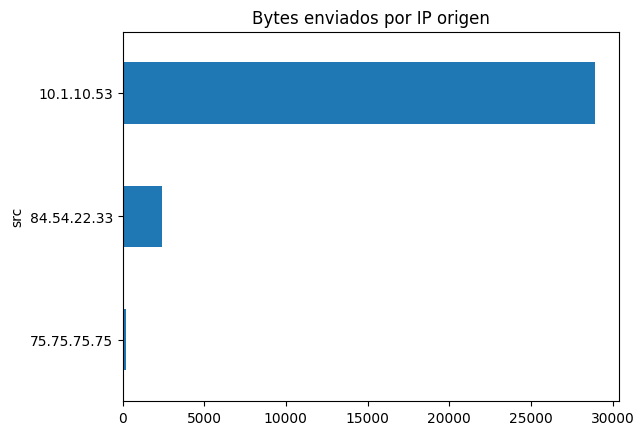

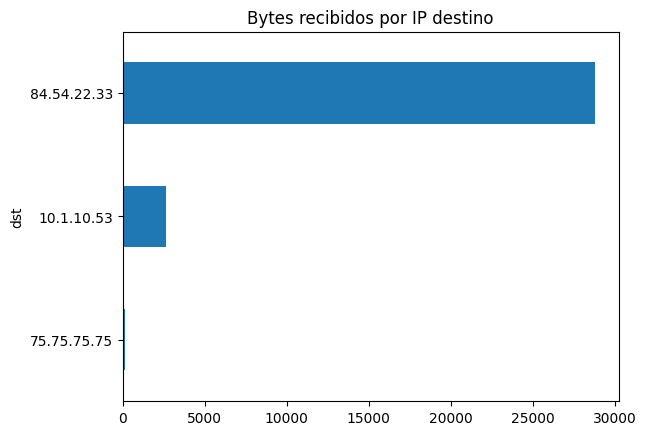

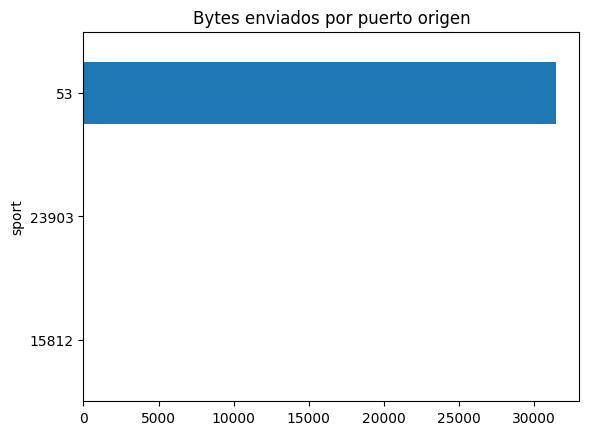

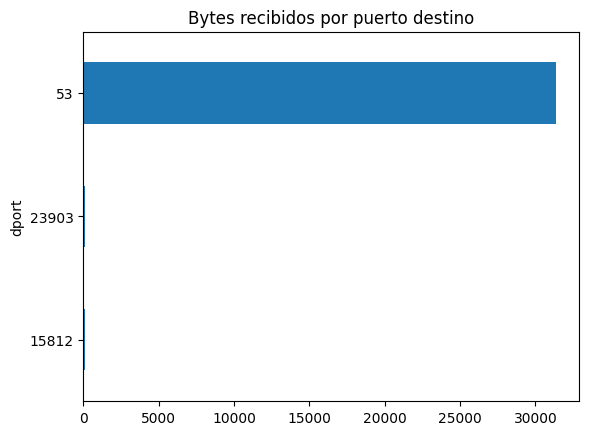

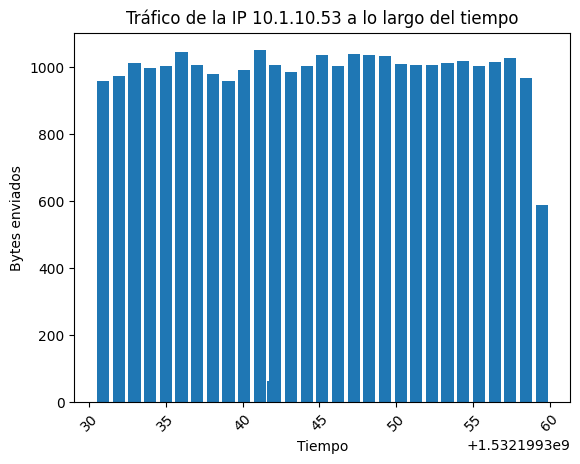

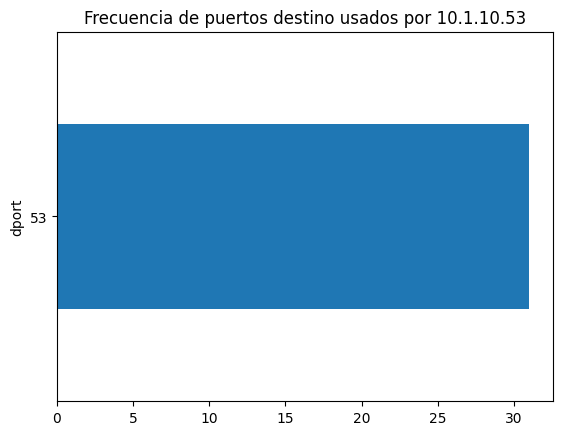

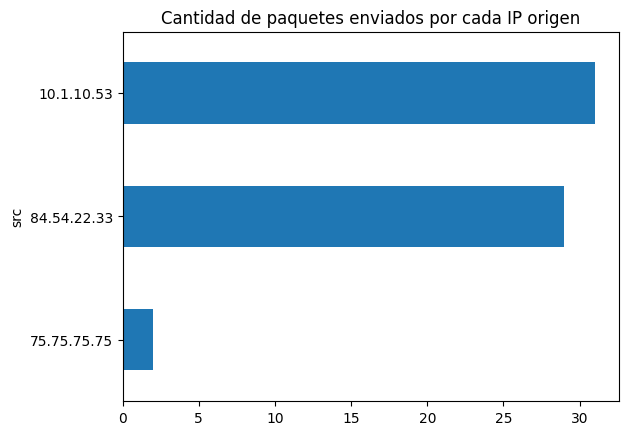

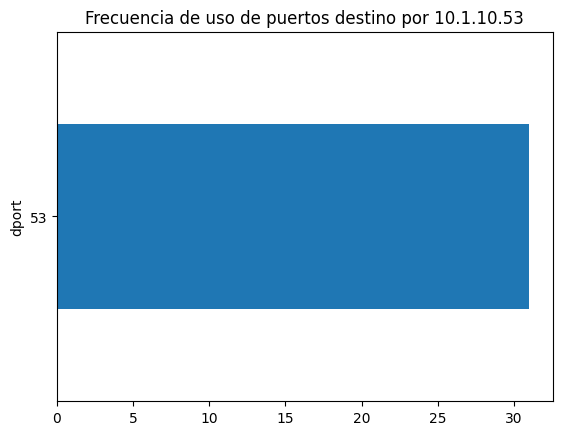

In [3]:
# Gráficas
df.groupby("src")["payload"].sum().sort_values().plot(kind='barh', title='Bytes enviados por IP origen')
plt.show()

df.groupby("dst")["payload"].sum().sort_values().plot(kind='barh', title='Bytes recibidos por IP destino')
plt.show()

# Graficar datos sin necesidad de condiciones
df.groupby("sport")["payload"].sum().sort_values().plot(kind='barh', title='Bytes enviados por puerto origen')
plt.show()

df.groupby("dport")["payload"].sum().sort_values().plot(kind='barh', title='Bytes recibidos por puerto destino')
plt.show()

# Gráfico payload vs tiempo
timestamps = df[df["src"] == ip_origen_frecuente]["time"]
payloads = df[df["src"] == ip_origen_frecuente]["payload"]
plt.bar(timestamps, payloads)
plt.xlabel("Tiempo")
plt.ylabel("Bytes enviados")
plt.title(f"Tráfico de la IP {ip_origen_frecuente} a lo largo del tiempo")
plt.xticks(rotation=45)
plt.show()

# Nueva gráfica: Distribución de puertos destino usados por la IP más frecuente
df[df["src"] == ip_origen_frecuente].groupby("dport")["payload"].count().sort_values().plot(kind='barh', title=f'Frecuencia de puertos destino usados por {ip_origen_frecuente}')
plt.show()

# Nueva gráfica: Cantidad de paquetes enviados por cada IP origen
df.groupby("src")["payload"].count().sort_values().plot(kind='barh', title='Cantidad de paquetes enviados por cada IP origen')
plt.show()

# Nueva gráfica: Frecuencia de puertos destino usados por la IP más frecuente
df[df["src"] == ip_origen_frecuente].groupby("dport")["payload"].count().sort_values().plot(kind='barh', title=f'Frecuencia de uso de puertos destino por {ip_origen_frecuente}')
plt.show()


In [4]:
# Filtrar conexiones sospechosas
df_sospechoso = df[df["src"] == ip_origen_frecuente]
df_agrupado = df_sospechoso.groupby("dst")["payload"].sum().reset_index()
ip_sospechosa = df_agrupado.sort_values("payload", ascending=False).iloc[0]["dst"]

df_conversacion = df[(df["src"] == ip_origen_frecuente) & (df["dst"] == ip_sospechosa)]
payloads_sospechosos = []

for pkt in packets:
    if pkt.haslayer(scapy.IP) and pkt[scapy.IP].src == ip_origen_frecuente and pkt[scapy.IP].dst == ip_sospechosa:
        if pkt.haslayer(scapy.Raw):
            payloads_sospechosos.append(pkt[scapy.Raw].load)

print("IP Origen Frecuente:", ip_origen_frecuente)
print("IP Destino Frecuente:", ip_destino_frecuente)
print("Puerto Destino Frecuente:", puerto_destino_frecuente)
print("IP Sospechosa:", ip_sospechosa)
print("Primeros 5 payloads sospechosos:", payloads_sospechosos[:5])

IP Origen Frecuente: 10.1.10.53
IP Destino Frecuente: 84.54.22.33
Puerto Destino Frecuente: 53
IP Sospechosa: 84.54.22.33
Primeros 5 payloads sospechosos: [b'\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xb

# PARTE 3

In [2]:
# Convertir paquetes a DataFrame
def extract_packet_info(packet):
    return {
        "src": packet[scapy.IP].src if packet.haslayer(scapy.IP) else None,
        "dst": packet[scapy.IP].dst if packet.haslayer(scapy.IP) else None,
        "payload": len(packet.payload)
    }

# a. Crear un DF con la dirección IP origen más frecuente
ip_origen_frecuente = df["src"].mode()[0]
df_frecuente = df[df["src"] == ip_origen_frecuente]

# b. Agrupar por IP destino y sumar payload
df_agrupado = df_frecuente.groupby("dst")["payload"].sum().reset_index()

# c. Obtener la IP destino con más bytes intercambiados
ip_sospechosa = df_agrupado.sort_values("payload", ascending=False).iloc[0]["dst"]

# d. Crear un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa
df_conversacion = df[(df["src"] == ip_origen_frecuente) & (df["dst"] == ip_sospechosa)]

# e. Extraer los payloads en un array
payloads_sospechosos = []
for pkt in packets:
    if pkt.haslayer(scapy.IP) and pkt[scapy.IP].src == ip_origen_frecuente and pkt[scapy.IP].dst == ip_sospechosa:
        if pkt.haslayer(scapy.Raw):
            payloads_sospechosos.append(pkt[scapy.Raw].load)

# f. Mostrar el contenido del array
print("Payloads sospechosos:", payloads_sospechosos[:5])

# g. Analizar los primeros bytes del contenido
def analizar_payloads(payloads):
    for i, payload in enumerate(payloads[:5]):
        print(f"Payload {i+1}: {payload[:20]}")  # Mostrar los primeros 20 bytes

analizar_payloads(payloads_sospechosos)


Payloads sospechosos: [b'\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x13\xef\xbf\xbdiaK\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xe